In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading dataset
df = pd.read_csv('./JEOPARDY_CSV.csv')

In [3]:
df

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams
...,...,...,...,...,...,...,...
216925,4999,2006-05-11,Double Jeopardy!,RIDDLE ME THIS,$2000,This Puccini opera turns on the solution to 3 ...,Turandot
216926,4999,2006-05-11,Double Jeopardy!,"""T"" BIRDS",$2000,In North America this term is properly applied...,a titmouse
216927,4999,2006-05-11,Double Jeopardy!,AUTHORS IN THEIR YOUTH,$2000,"In Penny Lane, where this ""Hellraiser"" grew up...",Clive Barker
216928,4999,2006-05-11,Double Jeopardy!,QUOTATIONS,$2000,"From Ft. Sill, Okla. he made the plea, Arizona...",Geronimo


In [4]:
df.shape

(216930, 7)

In [5]:
df.columns = df.columns.str.strip() # remove 

In [6]:
df.isnull().sum()
df[df['Answer'].isnull()]

,Show Number,Air Date,Round,Category,Value,Question,Answer
94817,4346,2003-06-23,Jeopardy!,"GOING ""N""SANE",$200,"It often precedes ""and void""",NaN
143297,6177,2011-06-21,Double Jeopardy!,NOTHING,$400,"This word for ""nothing"" precedes ""and void"" to...",NaN


In [7]:
df = df.dropna(subset=['Question', 'Answer', 'Category', 'Value'])
df['Value'] = pd.to_numeric(df['Value'].replace('[\$,]', '', regex=True), errors='coerce')
df['Value'].fillna(0, inplace=True)
df['Value'].head(), df['Value'].isna().sum()
df = df[df['Question'].str.contains('www')==False].reset_index(drop=True)
df = df[df['Category'].str.contains('missing')==False].reset_index(drop=True)
df

/var/folders/dk/mw1t_ffs6jd0418t437scbb00000gn/T/ipykernel_87044/3207396264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Value'] = pd.to_numeric(df['Value'].replace('[\$,]', '', regex=True), errors='coerce')
/var/folders/dk/mw1t_ffs6jd0418t437scbb00000gn/T/ipykernel_87044/3207396264.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Value'].fillna(0, inplace=True)


,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,200.0,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200.0,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200.0,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200.0,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200.0,"Signer of the Dec. of Indep., framer of the Co...",John Adams
...,...,...,...,...,...,...,...
206360,4999,2006-05-11,Double Jeopardy!,RIDDLE ME THIS,2000.0,This Puccini opera turns on the solution to 3 ...,Turandot
206361,4999,2006-05-11,Double Jeopardy!,"""T"" BIRDS",2000.0,In North America this term is properly applied...,a titmouse
206362,4999,2006-05-11,Double Jeopardy!,AUTHORS IN THEIR YOUTH,2000.0,"In Penny Lane, where this ""Hellraiser"" grew up...",Clive Barker
206363,4999,2006-05-11,Double Jeopardy!,QUOTATIONS,2000.0,"From Ft. Sill, Okla. he made the plea, Arizona...",Geronimo


In [8]:
def make_difficulty_col(df):
    
    # Define conditions for difficulty levels
    conditions = [
        # Easy: Jeopardy! round and value <= $2000
        (df['Round'] == 'Jeopardy!') & (df['Value'] <= 2000),  

        # Average: Jeopardy! round and value > $2000 OR
        #          Double Jeopardy! round and value <= $3000
        ((df['Round'] == 'Jeopardy!') & (df['Value'] > 2000)) |
        ((df['Round'] == 'Double Jeopardy!') & (df['Value'] <= 3000)),  

        # Hard: Double Jeopardy! round and value > $4000 OR
        #       Final Jeopardy! OR Tiebreaker
        ((df['Round'] == 'Double Jeopardy!') & (df['Value'] > 3000)) | 
        (df['Round'] == 'Final Jeopardy!') | (df['Round'] == 'Tiebreaker')
    ]
    
    difficulties = ['easy', 'average', 'hard']
    
    # Apply conditions to create the 'question_difficulty' column
    df['Difficulty'] = np.select(conditions, difficulties, default='average')
    
    return df

In [9]:
df = make_difficulty_col(df)
df

,Show Number,Air Date,Round,Category,Value,Question,Answer,Difficulty
0,4680,2004-12-31,Jeopardy!,HISTORY,200.0,"For the last 8 years of his life, Galileo was ...",Copernicus,easy
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200.0,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,easy
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200.0,The city of Yuma in this state has a record av...,Arizona,easy
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200.0,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,easy
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200.0,"Signer of the Dec. of Indep., framer of the Co...",John Adams,easy
...,...,...,...,...,...,...,...,...
206360,4999,2006-05-11,Double Jeopardy!,RIDDLE ME THIS,2000.0,This Puccini opera turns on the solution to 3 ...,Turandot,average
206361,4999,2006-05-11,Double Jeopardy!,"""T"" BIRDS",2000.0,In North America this term is properly applied...,a titmouse,average
206362,4999,2006-05-11,Double Jeopardy!,AUTHORS IN THEIR YOUTH,2000.0,"In Penny Lane, where this ""Hellraiser"" grew up...",Clive Barker,average
206363,4999,2006-05-11,Double Jeopardy!,QUOTATIONS,2000.0,"From Ft. Sill, Okla. he made the plea, Arizona...",Geronimo,average


In [10]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.sparse import hstack

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/kelly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kelly/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kelly/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text = "".join([char for char in text if char not in string.punctuation])
    text = " ".join([word for word in re.split('\W+', text) if word not in stop_words])
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [13]:
df['Question'] = df['Question'] .apply(clean_text)
df['Category'] = df['Category'].apply(clean_text)

In [14]:
df

,Show Number,Air Date,Round,Category,Value,Question,Answer,Difficulty
0,4680,2004-12-31,Jeopardy!,history,200.0,last 8 year life galileo house arrest espousin...,Copernicus,easy
1,4680,2004-12-31,Jeopardy!,espns top 10 alltime athlete,200.0,2 1912 olympian football star carlisle indian ...,Jim Thorpe,easy
2,4680,2004-12-31,Jeopardy!,everybody talk,200.0,city yuma state record average 4055 hour sunsh...,Arizona,easy
3,4680,2004-12-31,Jeopardy!,company line,200.0,1963 live art linkletter show company served b...,McDonald's,easy
4,4680,2004-12-31,Jeopardy!,epitaph tribute,200.0,signer dec indep framer constitution mass seco...,John Adams,easy
...,...,...,...,...,...,...,...,...
206360,4999,2006-05-11,Double Jeopardy!,riddle,2000.0,puccini opera turn solution 3 riddle posed her...,Turandot,average
206361,4999,2006-05-11,Double Jeopardy!,bird,2000.0,north america term properly applied 4 specie c...,a titmouse,average
206362,4999,2006-05-11,Double Jeopardy!,author youth,2000.0,penny lane hellraiser grew barber shave anothe...,Clive Barker,average
206363,4999,2006-05-11,Double Jeopardy!,quotation,2000.0,ft sill okla made plea arizona land home fathe...,Geronimo,average


In [15]:
# Feature extraction with TF-IDF
tfidf_vectorizer_q = TfidfVectorizer(max_features=1000)
text_tfidf = tfidf_vectorizer_q.fit_transform(df['Question'])

tfidf_vectorizer_c = TfidfVectorizer(max_features=1000)
category_tfidf = tfidf_vectorizer_c.fit_transform(df['Category'])
text_tfidf.shape

(206365, 1000)

In [16]:
# Define a mapping that reflects the natural ordering of difficulty
difficulty_mapping = {'easy': 0, 'average': 1, 'hard': 2}

# Apply the mapping to the 'Difficulty' column
df['Difficulty_Encoded'] = df['Difficulty'].map(difficulty_mapping)

print(df[['Difficulty', 'Difficulty_Encoded']])

       Difficulty  Difficulty_Encoded
0            easy                   0
1            easy                   0
2            easy                   0
3            easy                   0
4            easy                   0
...           ...                 ...
206360    average                   1
206361    average                   1
206362    average                   1
206363    average                   1
206364       hard                   2

[206365 rows x 2 columns]


In [17]:
text_tfidf_dense = text_tfidf.toarray()
category_tfidf_dense = category_tfidf.toarray()

# Combine all features into a single feature matrix
from scipy.sparse import hstack
features = np.hstack((text_tfidf_dense, category_tfidf_dense, df['Difficulty_Encoded'].values.reshape(-1, 1)))

features.shape

(206365, 2001)

In [18]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  

# Fit PCA on the scaled feature matrix and transform the data
features_pca = pca.fit_transform(features_scaled)

print("Original feature space:", features_scaled.shape[1])
print("Reduced feature space:", features_pca.shape[1])

Original feature space: 2001
Reduced feature space: 1825


/Users/kelly/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kelly/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kelly/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kelly/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

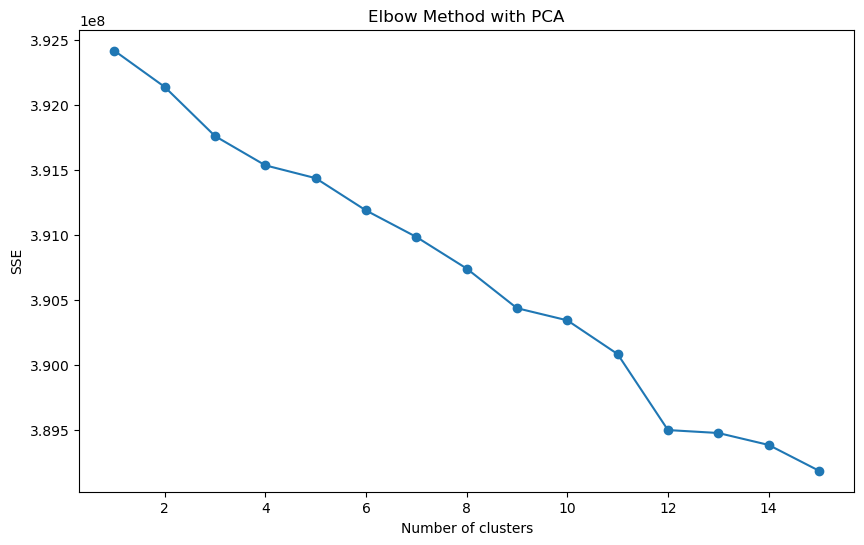

In [20]:
# Apply the elbow method on the reduced dataset from PCA
sse = []
for k in range(1, 16):  # Test k from 1 to 15
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)
    sse.append(kmeans.inertia_)

# Plot SSE for each k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), sse, marker='o')
plt.title('Elbow Method with PCA')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [21]:
#K-Means clustering 
num_clusters = 12
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features_pca)

/Users/kelly/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [22]:
# Assign clusters back to the original DataFrame for analysis
df['Cluster'] = clusters

# Output the first few rows of the DataFrame to inspect
print(df.head())

   Show Number    Air Date      Round                      Category  Value  \
0         4680  2004-12-31  Jeopardy!                       history  200.0   
1         4680  2004-12-31  Jeopardy!  espns top 10 alltime athlete  200.0   
2         4680  2004-12-31  Jeopardy!                everybody talk  200.0   
3         4680  2004-12-31  Jeopardy!                  company line  200.0   
4         4680  2004-12-31  Jeopardy!               epitaph tribute  200.0   

                                            Question      Answer Difficulty  \
0  last 8 year life galileo house arrest espousin...  Copernicus       easy   
1  2 1912 olympian football star carlisle indian ...  Jim Thorpe       easy   
2  city yuma state record average 4055 hour sunsh...     Arizona       easy   
3  1963 live art linkletter show company served b...  McDonald's       easy   
4  signer dec indep framer constitution mass seco...  John Adams       easy   

   Difficulty_Encoded  Cluster  
0                   0  

In [23]:
from sklearn.manifold import TSNE

/var/folders/dk/mw1t_ffs6jd0418t437scbb00000gn/T/ipykernel_87044/3369909687.py:15: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', palette=sns.color_palette("hsv", 10), data=df_tsne)


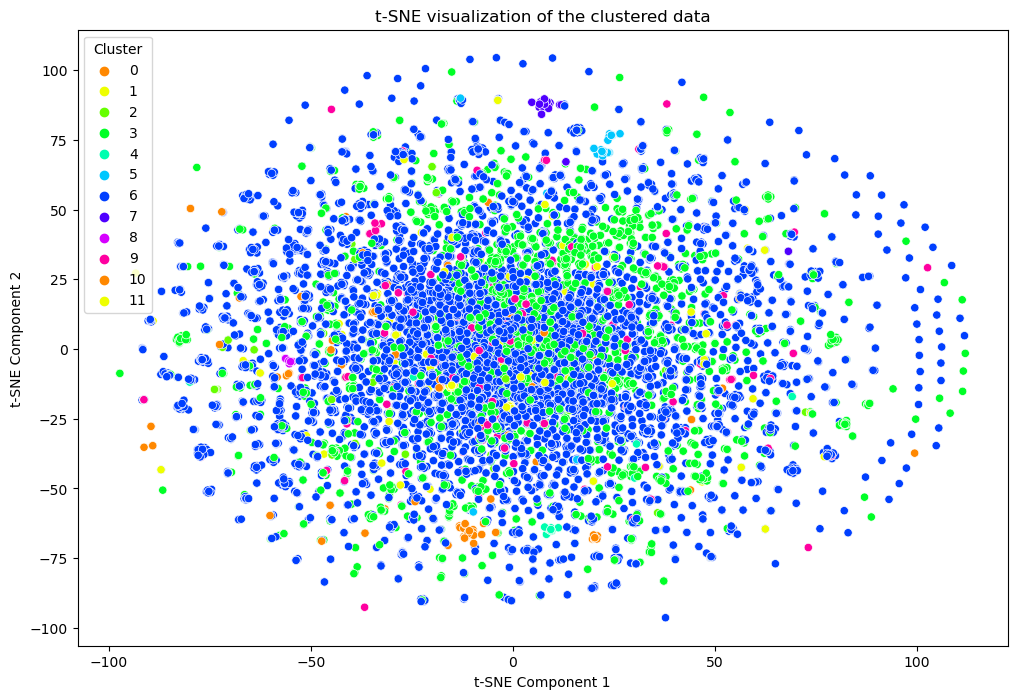

In [24]:
# t-SNE for dimensionality reduction to visualize the data
# Using a sample of the data to speed up the t-SNE process
sample_indices = np.random.choice(features_pca.shape[0], size=10000, replace=False)
features_sample = features_pca[sample_indices]

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
features_tsne = tsne.fit_transform(features_sample)

# Create a DataFrame for the sample data with t-SNE components and cluster assignments
df_tsne = pd.DataFrame(features_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Cluster'] = df['Cluster'].iloc[sample_indices].values

# Plot the clusters as per t-SNE components
plt.figure(figsize=(12, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', palette=sns.color_palette("hsv", 10), data=df_tsne)
plt.title('t-SNE visualization of the clustered data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

In [27]:
top_n = 5  # Number of top terms to extract

# Get feature names for questions and categories
question_feature_names = tfidf_vectorizer_q.get_feature_names_out()
category_feature_names = tfidf_vectorizer_c.get_feature_names_out()

for i in range(num_clusters):
    print(f"\nCluster {i}:")

    # Find indices of questions in the cluster
    cluster_indices = df[df['Cluster'] == i].index

    # Aggregate TF-IDF scores for these questions and categories
    question_tfidf_sum = np.array(np.sum(text_tfidf[cluster_indices], axis=0)).flatten()
    category_tfidf_sum = np.array(np.sum(category_tfidf[cluster_indices], axis=0)).flatten()

    # Get top terms in 'Question' and 'Category' for the cluster
    top_question_terms_indices = question_tfidf_sum.argsort()[-top_n:][::-1]
    top_category_terms_indices = category_tfidf_sum.argsort()[-top_n:][::-1]

    top_question_terms = [question_feature_names[idx] for idx in top_question_terms_indices]
    top_category_terms = [category_feature_names[idx] for idx in top_category_terms_indices]

    # Output the top question terms and category terms for the cluster
    print("Top Question Terms:", top_question_terms)
    print("Top Category Terms:", top_category_terms)

    # Get and output the most common categories in the cluster
    common_categories = df.loc[cluster_indices, 'Category'].value_counts().head(top_n)
    print(f"Common categories:\n{common_categories}\n")



Cluster 0:
Top Question Terms: ['prize', 'nobel', 'pulitzer', 'winner', 'peace']
Top Category Terms: ['prize', 'odds', 'nobel', 'pulitzer', 'end']
Common categories:
odds end             122
award                 31
nobel prize           20
literature            14
nobel peace prize     13
Name: Category, dtype: int64


Cluster 1:
Top Question Terms: ['record', 'wasnt', '1979', 'set', 'first']
Top Category Terms: ['sport', 'record', 'movie', 'music', 'name']
Common categories:
sport              25
guinness record    21
pop music          14
sport star         12
                   11
Name: Category, dtype: int64


Cluster 2:
Top Question Terms: ['desert', 'great', 'name', 'one', 'lake']
Top Category Terms: ['great', 'desert', 'geography', 'brit', 'lake']
Common categories:
desert             55
great brit         29
great lake         16
great dame         14
alexander great    10
Name: Category, dtype: int64


Cluster 3:
Top Question Terms: ['film', 'title', 'novel', 'played', 'play

In [26]:
# B. Analyzing Cluster Sizes and Difficulty
cluster_sizes = df['Cluster'].value_counts()
print(cluster_sizes)

# Calculate the proportion of difficulty levels within each cluster
for i in range(num_clusters):
    print(f"\nCluster {i} Difficulty Distribution:")
    # Select the subset of the DataFrame that corresponds to the current cluster
    cluster_subset = df[df['Cluster'] == i]
    
    # Use value_counts to get the count of each difficulty level, normalize=True gives the proportion
    difficulty_counts = cluster_subset['Difficulty'].value_counts(normalize=True)
    
    # Print the difficulty distribution
    print(difficulty_counts)



6     146666
3      46371
9       4581
11      2422
1       1658
0       1225
10      1039
2        792
5        633
7        513
4        332
8        133
Name: Cluster, dtype: int64

Cluster 0 Difficulty Distribution:
average    0.564898
easy       0.391837
hard       0.043265
Name: Difficulty, dtype: float64

Cluster 1 Difficulty Distribution:
easy       0.512666
average    0.454162
hard       0.033172
Name: Difficulty, dtype: float64

Cluster 2 Difficulty Distribution:
average    0.525253
easy       0.455808
hard       0.018939
Name: Difficulty, dtype: float64

Cluster 3 Difficulty Distribution:
average    0.551271
easy       0.423929
hard       0.024800
Name: Difficulty, dtype: float64

Cluster 4 Difficulty Distribution:
average    0.593373
easy       0.382530
hard       0.024096
Name: Difficulty, dtype: float64

Cluster 5 Difficulty Distribution:
average    0.560821
easy       0.394945
hard       0.044234
Name: Difficulty, dtype: float64

Cluster 6 Difficulty Distribution:
easy  